In [43]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh
from scipy.optimize import curve_fit
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
from scipy.special import eval_genlaguerre, gamma, hyp1f1

In [21]:
#N=10 #Dimension of the Hilbert Space
#S=5
dim=20
A=1 #Probability distribution will be P~exp(-A x^2)
sigma=np.sqrt(A/2)
#t_max=0.5
#n_points_t=50
#t_arr=np.linspace(0, t_max, n_points_t)
basis = np.identity(dim)
i=complex(0,1)
β=1
#tmax=np.log(dim)/(2*np.pi/β)*2
tmax=100
n_points_t=300
xlogscale=True
if xlogscale:
    auxtmin=-2
    auxtmax=np.log10(tmax)
    auxt=np.linspace(auxtmin, auxtmax, n_points_t)
    t_arr=10**(auxt)
else:
    t_arr=np.linspace(0, tmax, n_points_t)
Nav=500
hbar=1

In [22]:
#Construct a Random Gaussian Orthogonal Matrix GOE (Time Reversal Symmetry is present)
@numba.jit(float64[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GOE(N, sigma):
    auxH = np.random.randn(N,N) #Creates a random array normally distributed. Assumes sigma=1
    H=(auxH+auxH.T) #Summing any matrix and its transpose gives a symmetric matrix
    return H
#Construct a Random Gaussian Hermitian Matrix. GUE (No Time-Reversal Symmetry)
@numba.jit(complex128[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128) #Define a N x N matrix
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma) #The elements in the diagonal are real.
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2) #Elements out of diagonal
            b=np.random.normal(0,sigma)/np.sqrt(2) #Take care with the sqrt(2) dividing
            #With this sqrt(2) the average modulus of the random numbers is the same as in 
            #the diagonal
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    return H

#Compute the analytically continued partition function given the spectrum E of the system
#The β parameter may be complex valued.
@numba.jit(complex128(complex128, float64[:]))
def Z_c(β, E):
    Z=np.sum(np.exp(-β*E))
    return Z

In [23]:
def avZGUE(sigma, dim):
    return np.exp(sigma**2/4)*eval_genlaguerre(dim-1, 1, -sigma**2/2)
    #return np.exp(sigma**2/4)*GenLag(dim-1, 1, -sigma**2/2)
def gcGUE(sigma0, dim):
    gc=0
    for n in range(dim):
        for m in range(dim):
            cmn=factorial(np.min([n,m]))/factorial(np.max([n, m]))
            dnm=np.abs(n-m)
            minnm=np.min([n,m])
            poly=eval_genlaguerre(minnm, dnm, -sigma0**2/2)
            #poly=GenLag(dim-1, 1, -sigma0**2/2)
            gc+=cmn*(np.conjugate(sigma0)*sigma0/2)**dnm*np.conjugate(poly)*poly
            #psimn=hyp1f1(-m, 1+m-n, -sigma**2/2)/gamma(1+m-n)
            #gc+=(sigma/np.conjugate(sigma))**(m-n)*np.conjugate(psimn)*psimn
    return -np.exp((sigma0**2+(np.conjugate(sigma0))**2)/4)*gc
    #return np.exp((sigma0**2+(np.conjugate(sigma0))**2)/4)*gc

def avgGUE(beta, t, dim):
    Z=avZGUE(beta, dim)
    term1=avZGUE(2*beta, dim)
    term2=avZGUE(beta+i*t, dim)
    #term2=(np.abs(term2))**2
    term2=np.conjugate(term2)*term2
    term3=gcGUE(beta+i*t, dim)
    return (term1+term2+term3)
n_p_t=10000
if xlogscale:
    #t=np.linspace(10**auxtmin, tmax, 10000)
    auxt=np.linspace(auxtmin, auxtmax, n_p_t)
    t=10**auxt
else:
    t=np.linspace(0, tmax, n_p_t)

In [24]:
total=avgGUE(β, t, dim)
print(avgGUE(β, 0, dim), avZGUE(β, dim)**2)
#total0=avgGUE(β, 0, dim)
total0=(avZGUE(β, dim))**2
total=total/total0
term1=avZGUE(2*β, dim)*np.ones(n_p_t)/total0
term2=avZGUE(β+i*t, dim)
term2=np.conjugate(term2)*term2/total0
term3=gcGUE(β+i*t, dim)/total0

(302745.3554493521+0j) 278234.1804663993


In [25]:
def dsigmagc(s, dim):
    term2=0
    term3=0
    sc=np.conjugate(s)
    gc=gcGUE(s, dim)
    for n in range(dim):
        for m in range(dim):
            cmn=factorial(np.min([n,m]))/factorial(np.max([n, m]))
            dnm=np.abs(n-m)
            minnm=np.min([n,m])
            poly1=eval_genlaguerre(minnm, dnm, -s**2/2)
            #poly1c=np.conjugate(poly1)
            poly1c=eval_genlaguerre(minnm, dnm, -sc**2/2)
            if minnm==0:
                poly2=0
            else:
                poly2=eval_genlaguerre(minnm-1, dnm+1, -s**2/2)
            if dnm==0:
                term2+=0
            else:
                term2+=cmn*dnm*(s*sc/2)**(dnm-1)*sc/2*poly1*poly1c
            term3+=cmn*(s*sc/2)**dnm*poly2*poly1c*s
    return (s/2*gc-np.exp((s**2+sc**2)/4)*(term2-term3))

def dsigmacgc(s, dim):
    term2=0
    term3=0
    sc=np.conjugate(s)
    gc=gcGUE(s, dim)
    for n in range(dim):
        for m in range(dim):
            cmn=factorial(np.min([n,m]))/factorial(np.max([n, m]))
            dnm=np.abs(n-m)
            minnm=np.min([n,m])
            poly1=eval_genlaguerre(minnm, dnm, -s**2/2)
            poly1c=eval_genlaguerre(minnm, dnm, -sc**2/2)
            if minnm==0:
                poly2c=0
            else:
                poly2c=eval_genlaguerre(minnm-1, dnm+1, -sc**2/2)
            if dnm==0:
                term2+=0
            else:
                #term2+=cmn*dnm*(s*sc/2)**(dnm-1)*sc/2*poly1*poly1c
                term2+=cmn*dnm*(s*sc/2)**(dnm-1)*s/2*poly1*poly1c
            term3+=cmn*(s*sc/2)**dnm*poly1*poly2c*sc
    return (sc/2*gc-np.exp((s**2+sc**2)/4)*(term2-term3))

In [26]:
def dtgc(b, t, dim):
    term2=0
    term3=0
    term4=0
    s=b+i*t
    sc=b-i*t
    gc=gcGUE(s, dim)
    for n in range(dim):
        for m in range(dim):
            cmn=factorial(np.min([n,m]))/factorial(np.max([n, m]))
            dnm=np.abs(n-m)
            minnm=np.min([n,m])
            poly1=eval_genlaguerre(minnm, dnm, -(b+i*t)**2/2)
            poly1c=eval_genlaguerre(minnm, dnm, -(b-i*t)**2/2)
            if minnm==0:
                poly2c=0
                poly2=0
            else:
                poly2c=eval_genlaguerre(minnm-1, dnm+1, -(b-i*t)**2/2)
                poly2=eval_genlaguerre(minnm-1, dnm+1, -(b+i*t)**2/2)
            term2+=cmn*dnm*((b**2+t**2)/2)**(dnm-1)*t*poly1*poly1c
            term3+=cmn*((b**2 + t**2)/2)**dnm*poly2*poly1c*i*(b+i*t)
            term4+=-cmn*((b**2 + t**2)/2)**dnm*poly1*poly2c*i*(b-i*t)
    return (-t*gc+np.exp((b**2-t**2)/2)*(-term2 - term3 -term4))/(np.abs(avZGUE(b, dim)))**2

In [27]:
def dZ2dt(β, t):
    L1t=eval_genlaguerre(dim-1, 1,-(β+i*t)**2/2)
    L2t=eval_genlaguerre(dim-2, 2,-(β+i*t)**2/2)
    L1tc=eval_genlaguerre(dim-1, 1,-(β-i*t)**2/2)
    L2tc=eval_genlaguerre(dim-2, 2,-(β-i*t)**2/2)
    adFdt=np.exp(-t**2/2)*L1t*L1tc/L1**2*(-t+i*(β+i*t)*L2t/L1t-i*(β-i*t)*L2tc/L1tc)
    return adFdt

In [28]:
#F_arr=np.zeros((n_points_t, Nav), dtype=complex)
F_Z_arr=np.zeros((n_points_t, Nav), dtype=complex)
avE_arr=np.zeros(Nav)
avE2_arr=np.zeros(Nav)
E0_arr=np.zeros(Nav)
Z_arr=np.zeros(Nav)
for j in range(Nav):
    H=RMT_GUE(dim, sigma) #Create random Matrix from GUE
    E, ket_n=eigh(H) #Diagonalize it
    if np.any(np.imag(E)>1e-8): 
        print("Problems") #Ensures that we have real eigenvalues
        print(np.max(np.imag(E)))
    Z=np.real(Z_c(β, E)) #Computes the partition function at temperature β
    Z_arr[j]=Z #Stores the partition function in an array to average it
    #avE_arr[j]=np.sum(np.exp(-β*E)*E)/Z
    avE_arr[j]=np.sum(np.exp(-β*E)*E)
    #avE2_arr[j]=np.sum(np.exp(-β*E)*E**2)/Z
    avE2_arr[j]=np.sum(np.exp(-β*E)*E**2)
    E0_arr[j]=np.min(E)
    for k in range(n_points_t):
        #F_arr[k,j]=F(y, Z, E, ket_n, t_arr[k])
        Zaux1=Z_c(β+i*t_arr[k], E) #Computes the analytically continued partition function
        Zaux2=Z_c(β-i*t_arr[k], E)
        F_Z_arr[k,j]=Zaux1*Zaux2/Z**2
avZ=np.average(Z_arr) #Average Partition function
avE_num=np.average(avE_arr)/avZ
avE2=np.average(avE2_arr)/avZ
deltaE_num=np.sqrt(avE2-avE_num**2)
E0_num=np.average(E0_arr)

#F_t=np.average(F_arr, axis=1)
F_Z=np.average(F_Z_arr, axis=1)#Annealed OTOC 
#sigmaF_t=np.std(np.real(F_arr), axis=1) #Standard deviation of F

/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


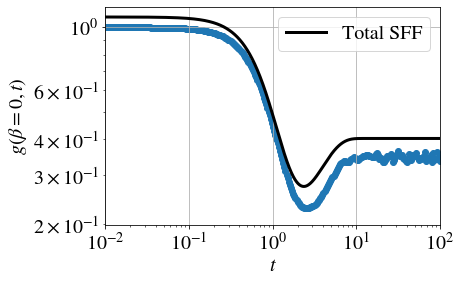

In [29]:
plt.figure()
plt.plot(t, total, label='Total SFF', color='black', lw=3)
plt.scatter(t_arr, F_Z)
#plt.plot(t, term1, label='Term 1', color='orange', lw=2)
#plt.plot(t, -term3, label='Term 2', ls='-.', color='red', lw=2)
#plt.plot(t, (1 - dim*0.5*t**2+(t**2/2)**2*(5*dim**2-1)/12)*dim**2, label='$o(t^4)$ approx.', ls='--')
#plt.plot(t, dim**2*(1 - ((dim-1)**2/4)*(t**2/2)**2 - (dim -1)*(t**2/2))*np.exp(-t**2/2))
#plt.plot(t, np.exp(-dim*t**2/2)*dim**2, label=r"$e^{- N t^2/2}$", ls='--')
#plt.plot(t, np.exp(-(dim+3)*(t-0.5)), label=r"$e^{- N (t-t^*)}$", ls=':', lw=3)
#plt.plot(t, (dim**2 - 0.5*np.exp(dim*(t))))
#plt.plot(t, aux)
#plt.plot(t, aux2, ls='--')
#plt.plot(t, term3, label='Term 3', color='blue', lw=2)
plt.xscale('log')
plt.grid()
plt.xlim(t[0], t[-1])
plt.yscale('log')
#plt.ylim(1e-1, 2)
plt.xlabel("$t$")
plt.ylabel(r"$g(\beta=0, t)$")
plt.legend(labelspacing=0)
plt.show()

In [30]:
F_t=F_Z
dFdt=np.zeros(n_points_t)
for k in range(1, n_points_t):
    dFdt[k]=(F_t[k]-F_t[k-1])/(t_arr[k]-t_arr[k-1])
E0=-np.sqrt(2*dim)
L1=eval_genlaguerre(dim-1, 1,-β**2/2)
L2=eval_genlaguerre(dim-2, 2,-β**2/2)
L3=eval_genlaguerre(dim-3, 3,-β**2/2)
avE=-(β/2+β*L2/L1)
varE=0.5*(1)+L2/L1+β**2*L3/L1-β**2*(L2/L1)**2
DeltaE=np.sqrt(varE)
BuresAng=np.arccos(np.sqrt(F_t))
#BuresAng=np.pi/2
#print(BuresAng)
#tQSL=BuresAng*np.max([1/DeltaE, 1/(avE-E0)])
#tMT=BuresAng/DeltaE
tMT=BuresAng/deltaE_num
#tML=BuresAng/(avE-E0)
tML=BuresAng/(avE_num-E0_num)
tQSL=BuresAng*np.max([1/DeltaE, 1/(avE_num-E0_num)])

/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [31]:
adFdt=dZ2dt(β, t)
print(np.max(np.abs(np.imag(adFdt))))
adFdt=np.real(adFdt)
#dgcdt=i*(dsigmagc(β+i*t, dim)-dsigmacgc(β+i*t, dim))
dgcdt=dtgc(β, t, dim)
#dgcdt=dgcdt/(np.abs(avZGUE(β, dim)))**2

1.0646200869936633e-16


In [32]:
print(np.max(np.abs(np.imag(dgcdt))))

6.897737340031221e-16


/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


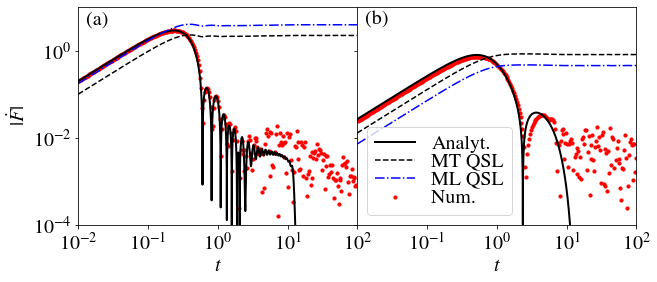

In [46]:
fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, figsize=[10, 4])
plt.subplots_adjust(wspace=0)
ax1.scatter(t_arr, Fdot_b0, s=10, color='red', label="Num. ")
ax1.plot(t, Fdot_an_b0, color='black', lw=2, label="Analyt.")
ax1.plot(t_arr, MT_b0, ls='--', color='black', label="MT QSL")
ax1.plot(t_arr, ML_b0, ls='-.', color='blue', label="ML QSL")

ax2.scatter(t_arr, np.abs(dFdt), s=10, color='red', label="Num. ")
ax2.plot(t, np.abs(adFdt+dgcdt), color='black', lw=2, label="Analyt.")
#plt.plot(t, np.abs(adFdt), color='green', lw=3)
ax2.plot(t_arr, (1-F_t)/tMT, ls='--', color='black', label="MT QSL")
ax2.plot(t_arr, (1-F_t)/tML, ls='-.', color='blue', label="ML QSL")
#plt.plot(t_arr, (1-F_t)/tQSL, ls=':', color='green', lw=5)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim(t[0], t[-1])
ax1.set_ylim(1e-4, 1e1 )
ax1.set_xlim(t[0], t[-1])
ax2.legend(labelspacing=0)
ax1.set_xlabel("$t$")
ax1.set_ylabel(r"$|\dot{F}|$")
ax1.text(1.3e-2, 4, "(a)")
ax2.text(1.3e-2, 4, "(b)")
ax2.set_xlabel("$t$")
ax2.set_xticks([1e-1, 1, 10, 100])
ax1.set_xticks([1e-2, 1e-1, 1, 10, 100])
plt.show()

In [34]:
"""MT_b0=(1-F_t)/tMT
ML_b0=(1-F_t)/tML
Fdot_b0=np.abs(dFdt)
Fdot_an_b0=np.abs(adFdt+dgcdt)"""

'MT_b0=(1-F_t)/tMT\nML_b0=(1-F_t)/tML\nFdot_b0=np.abs(dFdt)\nFdot_an_b0=np.abs(adFdt+dgcdt)'